# Unit 4 - Causal Inference

We are going to combine our knowledge of regression and classification methods to estimate causal effects in observational data.

We will play around with two datasets of two different kinds:
- Average effect (sodium)
- Heterogeneous effect (toy dataset)

Steps we are going to take:
1. Importing packages.
2. Average effect:
  1. Problem description.
  2. Evaluation metrics.
  3. Loading and exploring the data.
  4. Data pre-processing.
  5. Training the models.
  6. Performance evaluation.
3. Heterogeneous effect:
  1. Repeat the same steps as for the average effect.

## Step 1 - packages

Google Colab has loads of pre-installed packages already. What if we need more? We can install additional packages by knowing that:
- The exclamation mark ('!') gives us access to the Linux command line that runs behind our notebook.
- We can access the default python's package manager with the command 'pip'.

In our case, we are interested in using the [EconML](https://econml.azurewebsites.net/index.html) package, which is not part of the default Colab environment. We can install it via the following command:

In [1]:
# !pip install econml

     |████████████████████████████████| 3.3 MB 7.5 MB/s 
     |████████████████████████████████| 356 kB 50.8 MB/s 
     |████████████████████████████████| 123 kB 37.5 MB/s 
     |████████████████████████████████| 77 kB 6.1 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491648 sha256=47e8334cc6f61e815d5475888664aeb001a8b340aa6152b113be627c11525807
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


Note this command has to be executed everytime you restart the notebook.

Note to people using local Jupyter notebooks - you will have to execute the pip command in your local environment. It may not work from the notebook itself.

Now, we can import anything we need from EconML, together with the rest of the packages we need.

In [133]:
from econml.metalearners import XLearner
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import dataclasses

## Step 2 - Average effect

### Step 2.1 - problem setting



This is a simplified version of a model that simulates the effect of sodium intake on blood pressure. Officially proposed in ([Luque-Fernandez et al. 2019](https://academic.oup.com/ije/article/48/2/640/5248195)).


We are given three covariates: age (A), sodium (S), and blood pressure (B). We are interested in the effect of sodium intake on blood pressure. In addition, we know that age affects both variables - confounder. Here is the assumed causal graph:

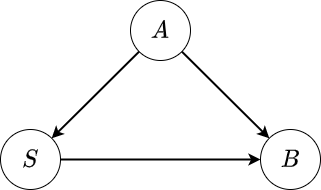

The code that implements the simulation can be found in [sodium_generate.py](https://github.com/dmachlanski/CE888_2022/blob/main/lab4/data/sodium_generate.py) script. This data generation process can be also described as follows:

$$A = \mathcal{N}(65, 5)$$ \\
$$
S=
    \begin{cases}
        1 & \text{ if } A/18 + \mathcal{N}(0, 1) > 3.5 \\ 
        0 & \text{ otherwise } 
    \end{cases}
$$ \\
$$B = ATE \times S + 2 A + \mathcal{N}(0, 1)$$ \\
$$ATE = 1.05$$

Note we assume the same effect across the entire population and fix it to an arbitrary scalar.

With this setting, we generate 10,000 samples and obtain file [sodium_10k.npz](https://github.com/dmachlanski/CE888_2022/blob/main/lab4/data/sodium_10k.npz).

Because we know the true ATE used in the data generation process, we can evaluate our models' performance by measuring how close their predicted ATE ($\widehat{ATE}$) is to the true one. More formally, we can write ATE as:

$$ATE = \mathbb{E}[\mathcal{Y}_1 - \mathcal{Y}_0]$$

And predicted ATE as:

$$\widehat{ATE} = \frac{1}{n}\sum \limits_{i=1}^{n}(\hat{y}_1^{(i)} - \hat{y}_0^{(i)})$$

Where $\hat{y}_t^{(i)}$ denotes predicted potential outcome for treatment $t$ and individual $(i)$. We can thus see that ATE is essentially the average of individual treatment effects, that is:

$$\widehat{ATE} = \frac{1}{n}\sum \limits_{i=1}^{n}\widehat{ITE}^{(i)}$$

One commonly used metric that we will use here measures the absolute difference between the predicted and true ATE, that is:

$$\epsilon_{ATE} = \left| \widehat{ATE} - ATE \right|$$

This metric works properly when the same average effect applies to all units in the dataset. In some cases, effects can vary across groups of units. In other words, we can say that the effect is heterogeneous. For those cases, it is useful to also include another metric that captures the errors made per each individual predicted ITE. This metric is PEHE:

$$\epsilon_{PEHE}=\sqrt{\frac{1}{n}\sum_{i=1}^{n}( \hat{y}_1^{(i)}  - \hat{y}_0^{(i)} - (\mathcal{Y}_1^{(i)} - \mathcal{Y}_0^{(i)}))^2}$$

Which can be simplified to:

$$\epsilon_{PEHE}=\sqrt{\frac{1}{n}\sum_{i=1}^{n}( \widehat{ITE}^{(i)} - ITE^{(i)})^2}$$

### Step 2.2 - metrics

Here, we are going to implement the two metrics discussed in the previous step 2.1: $\epsilon_{ATE}$ and $\epsilon_{PEHE}$.

You should have already implemented both metrics as part of the Moodle quiz. Feel free to copy the code from your quiz answers or write the code from scratch.

In [25]:
def abs_ate(effect_true, effect_pred):
    """
    Absolute error for the Average Treatment Effect (ATE)
    :param effect_true: true treatment effect value
    :param effect_pred: predicted treatment effect value
    :return: absolute error on ATE
    """

    return np.abs(np.mean(effect_true) - np.mean(effect_pred))

def pehe(effect_true, effect_pred):
    """
    Precision in Estimating the Heterogeneous Treatment Effect (PEHE)
    :param effect_true: true treatment effect value
    :param effect_pred: predicted treatment effect value
    :return: PEHE
    """
    return np.sqrt(np.mean(np.square(effect_true - effect_pred)))


    

### Step 2.3 - data

The sodium dataset is in the form of numpy's '.npz' file. Thus, we cannot use the usual 'read_csv' from pandas. This file must be downloaded first and loaded locally.

We can do this by either manually uploading the file to Colab, or via the following command that downloads the file to Colab automatically:

In [26]:
!wget https://github.com/dmachlanski/CE888_2022/raw/main/lab4/data/sodium_10k.npz

--2022-02-11 13:21:50--  https://github.com/dmachlanski/CE888_2022/raw/main/lab4/data/sodium_10k.npz
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dmachlanski/CE888_2022/main/lab4/data/sodium_10k.npz [following]
--2022-02-11 13:21:51--  https://raw.githubusercontent.com/dmachlanski/CE888_2022/main/lab4/data/sodium_10k.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 320962 (313K) [application/octet-stream]
Saving to: ‘sodium_10k.npz.2’

sodium_10k.npz.2    100%[===================>] 313.44K  --.-KB/s    in 0.03s   

2022-02-11 13:21:51 (12.0 MB/s) - ‘sodium_10k.npz.2’ saved [320962/320962]


You can check in the panel on the left that the file is there.

Now, let's load the file with numpy's 'load' function

In [27]:
data = np.load('sodium_10k.npz')

We can see what variable names are available by examining the 'files' property.

In [28]:
data.files

['x', 't', 'y', 'ite']

Variable names:
- X -> A (age; background variable)
- T -> S (sodium intake; treatment variable)
- Y -> B (blood pressure; outcome variable)
- ITE -> individual treatment effect


In [29]:
for f in data.files:
  print(f'{f}: {data[f].shape}')

x: (10000,)
t: (10000,)
y: (10000,)
ite: (10000,)


As we can see above, we have four single-dimensional vectors, each of which consisting of 10,000 samples. We are going to reshape them to 2D vectors as some methods prefer this representation of data, though we will have to switch back and forth between 1D and 2D representation often as this requirement varies across methdos.

In [57]:
X = data['x'].reshape(-1, 1)
T = data['t'].reshape(-1, 1)
Y = data['y'].reshape(-1, 1)
ite = data['ite']

X.shape

Let's plot the distributions of all three.

In [125]:
def histogrammer(X, Y, T, ite, bins=20, fig_suffix=None):
  if fig_suffix is None:
    fig_suffix = ""
  else:
    fig_suffix = f" {fig_suffix}"

  fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(16, 4))

  for a in (ax0, ax1, ax2, ax3):
    #a.grid(which='major', color='#DDDDDD', linewidth=0.8)
    #a.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    #a.minorticks_on()
    pass

  ax0.hist(X, bins=bins)
  ax0.set_title(f"X{fig_suffix}")
  ax1.hist(T, bins=bins)
  ax1.set_title(f"T{fig_suffix}")
  ax2.hist(Y, bins=bins)
  ax2.set_title(f"Y{fig_suffix}")
  ax3.hist(ite, bins=bins)
  ax3.set_title(f"ITE{fig_suffix}")

  

  fig.suptitle(f"X,T,Y,ITE histograms{fig_suffix}")
  return fig


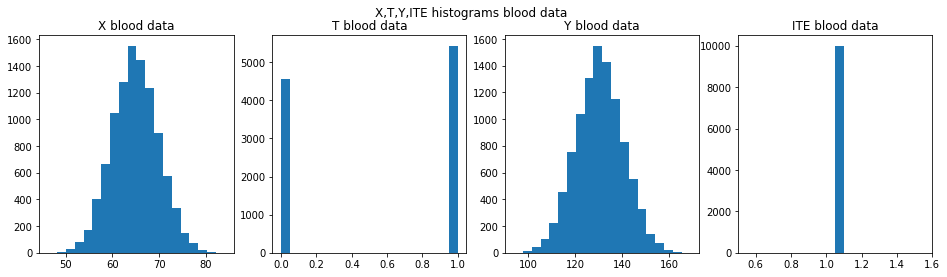

In [126]:
histogrammer(X,Y,T, ite, 20, fig_suffix="blood data").show()

X and Y clearly follow the shape of the normal distribution, as expected. T is binary, i.e., consists of 0 and 1 values. All ITE values are slightly higher than 1.0, which is correct as we know the ATE is 1.05.

In [32]:
np.mean(ite)

Let's do some scatter plots as well to explore the data. We will limit ourselves to just a fraction of the data for visualisation purposes, but feel free to play around with the 'limit' number.

In [98]:
def data_visualizer(X, Y, T, limit = None, fig_suffix = None):
  if limit is None:
    limit = X.shape[0]
  
  if fig_suffix is None:
    fig_suffix = ""
  else:
    fig_suffix = f" {fig_suffix}"
  
  fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(19.2, 4.8), sharex=True, sharey=True)
  ax0.set_title("both")
  ax1.set_title("treated only")
  ax2.set_title("control only")
  ax0.scatter(X[T == 1][:limit], Y[T == 1][:limit], c = "r", label = "Treated")
  ax1.scatter(X[T == 1][:limit], Y[T == 1][:limit], c = "r", label = "Treated")
  ax0.scatter(X[T == 0][:limit], Y[T == 0][:limit], c = "g", label = "Control")
  ax2.scatter(X[T == 0][:limit], Y[T == 0][:limit], c = "g", label = "Control")
  for a in (ax0, ax1, ax2):
    a.grid(which='major', color='#DDDDDD', linewidth=0.8)
    a.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    a.minorticks_on()
  fig.suptitle(f"Treatment/control data{fig_suffix}")
  fig.legend(ncol=2)
  return fig


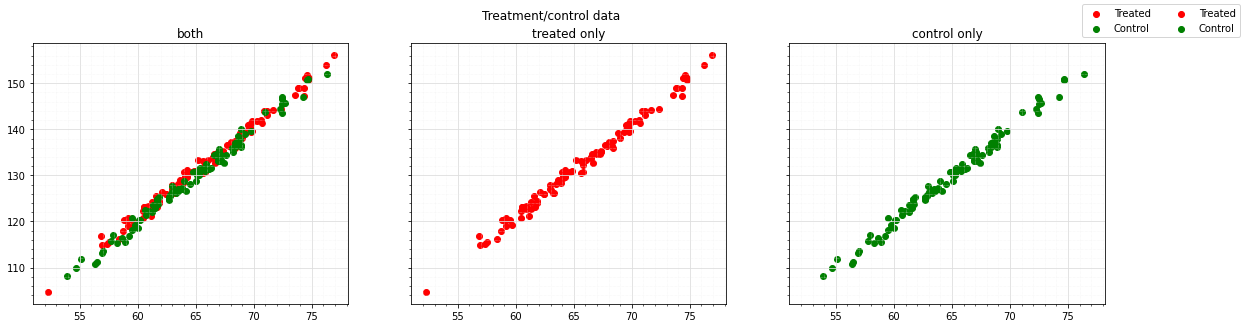

In [99]:
limit = 100


data_visualizer(X,Y,T,limit).show()

The effect is difficult to notice as it is quite small (1.05), nevertheless, in some regions the treated units (red) are a bit higher than the control ones (gree), which demonstrates the effect (treated units have higher outcomes).

### Step 2.4 - data pre-processing

Split the data into training and testing for evaluation purposes with 80/20 ratio.

In [61]:
x_train, x_test, t_train, t_test, y_train, y_test, ite_train, ite_test = train_test_split(X, T, Y, ite, test_size=0.2)

scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)



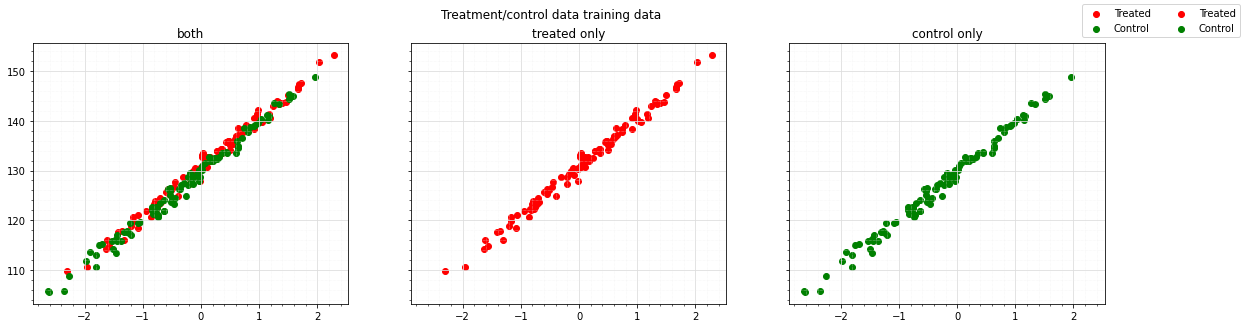

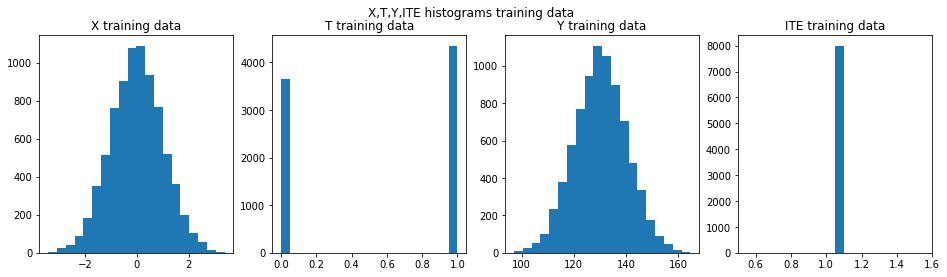

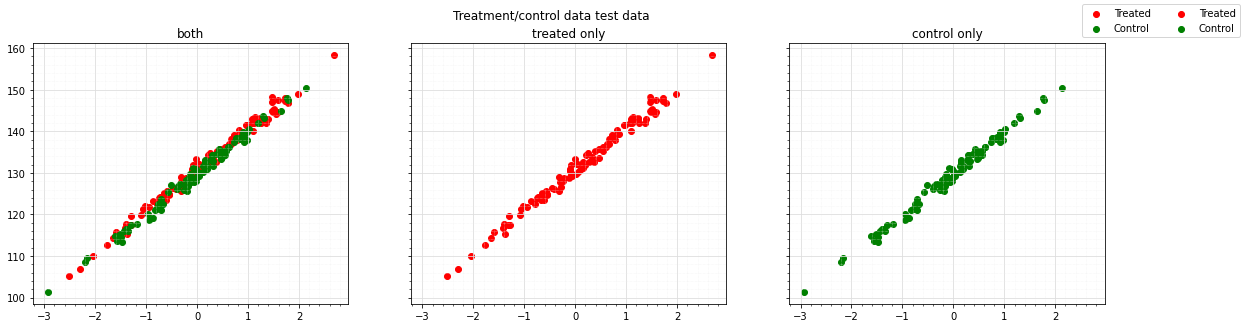

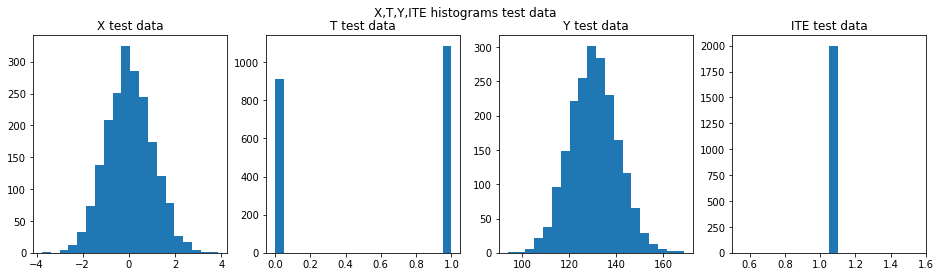

In [127]:
data_visualizer(x_train,y_train,t_train,limit, fig_suffix="training data").show()

histogrammer(x_train, y_train,t_train, ite_train, fig_suffix="training data").show()

data_visualizer(x_test,y_test,t_test,limit, fig_suffix="test data").show()

histogrammer(x_test,y_test,t_test, ite_test, fig_suffix="test data").show()

In [73]:
xt_train = np.hstack((x_train, t_train))
xt_train.flags.writeable = False

xt0_test = np.hstack((x_test, np.zeros_like(t_test)))
xt0_test.flags.writeable = False

xt1_test = np.hstack((x_test, np.ones_like(t_test)))
xt1_test.flags.writeable = False

In [180]:
from sklearn.base import RegressorMixin
from sklearn.ensemble._forest import BaseForest

from typing import Union

def get_ps_weights(clf, x, t):
  ti = np.squeeze(t)
  clf.fit(x, ti)
  ptx = clf.predict_proba(x).T[1].T + 0.0001 # add a small value to avoid dividing by 0
  # Given ti and ptx values, compute the weights wi (see formula above):
  wi = ti/ptx + ((1-ti)/(1-ptx))
  return wi

@dataclasses.dataclass(init=True, repr=True, eq=True, frozen=True)
class LearnerOutputs:

  learner: Union[RegressorMixin, XLearner]
  ite_pred: np.ndarray
  abs_ate: float
  pehe: float

  @classmethod
  def make(cls, regressor, xt_training, y_training, xt0_testing, xt1_testing, ite_real):

    reg = regressor.fit(xt_training, y_training)

    t0 = reg.predict(xt0_testing)
    t1 = reg.predict(xt1_testing)
    ite = t1 - t0

    return cls(reg, ite, abs_ate(ite_real, ite), pehe(ite_real, ite))

  @classmethod
  def make_sampleweights(cls, regressor, xt_training, y_training, xt0_testing, xt1_testing, weights, ite_real):

    reg = regressor.fit(xt_training, y_training, sample_weight=weights)
    t0 = reg.predict(xt0_testing)
    t1 = reg.predict(xt1_testing)
    ite = t1 - t0
    return cls(reg, ite, abs_ate(ite_real, ite), pehe(ite_real, ite))

  @classmethod
  def make_xlearner(cls, xl_models, prop_model, x_training, y_training, t_training, x_testing, ite_real, cate_models=None):
    xl: XLearner = XLearner(models=xl_models, propensity_model=prop_model, cate_models=cate_models)
    xl.fit(y_training, t_training.flatten(), X=x_training)
    ite = xl.effect(x_testing)
    return cls(xl,ite, abs_ate(ite_real, ite), pehe(ite_real, ite))

  @classmethod
  def make_cate(cls, cate_model, x_training, y_training, t_training, x_testing, ite_real):
    cate_model.fit(y_training, t_training.flatten(), X=x_training)
    ite = cate_model.effect(x_testing)
    return cls(cate_model, ite, abs_ate(ite_real, ite), pehe(ite_real, ite))

  def ate(self, effect_true):
    return abs_ate(effect_true, self.ite_pred)

  def calc_pehe(self, effect_true):
    return pehe(effect_true, self.ite_pred)


### Step 2.5 - training

We are going to use three estimators here:
- Random forest (RF; regressor).
- Random forest with Inverse Propensity Weighting (IPW).
- X-learner with RF as base learners.

#### Random Forest

##### Description

With random forests we simply model $P(Y|X, T)$, that is, we regress Y on X and T. Once trained, the model predicts potential outcomes $\hat{y}_t^{(i)}$. Thus, to obtain ITE predictions for each individual, we need to predict both $\hat{y}_0$ and $\hat{y}_1$, that is, predict the outcomes for both control and treated settings for each individual.

By calculating the difference between the treated and control outcome, we can obtain the effect per given individual. In other words:

$$\widehat{ITE}^{(i)} = \hat{y}_1^{(i)} - \hat{y}_0^{(i)}$$

##### Usage

In [181]:
# Random Forest with default parameters.
rf = RandomForestRegressor()

# Train on the training data.
# In the supervised setting, our usual X here consists of X and T.
# The target is Y - the outcome.
# Input: [X, T], output: Y.
# Hint: use np.concatenate or np.hstack functions to merge X and T.

#xt_train = np.hstack((x_train, t_train))
rf.fit(xt_train, y_train.flatten())

# Predictions
# Note we set T to a specific value for ALL individuals.
# These are interventional distributions - P(Y|X, do(T=t)).

# Predict Y_0 given [X, 0]
# Hint: use np.zeros_like or np.zeros functions to get the zeros for all units.
# Hint 2: you still have to merge X and zeros (see training above).

#xt0_test = np.hstack((x_test, np.zeros_like(t_test)))
rf_y0_test = rf.predict(xt0_test)

# Predict Y_1 given [X, 1]
# Hint: use np.ones_like or np.ones functions to get the ones for all units.
# Hint 2: you still have to merge X and ones (see training above).
#xt1_test = np.hstack((x_test, np.ones_like(t_test)))
rf_y1_test = rf.predict(xt1_test)

# Compute ITEs
# ITE = Y_1 - Y_0
rf_te_test = rf_y1_test - rf_y0_test

#print(rf_te_test)



rf_te = LearnerOutputs.make(RandomForestRegressor(), xt_train, y_train.flatten(), xt0_test, xt1_test, ite_test)


print(rf_te)

LearnerOutputs(learner=RandomForestRegressor(), ite_pred=array([1.17176493, 2.21187384, 0.44872112, ..., 1.83764147, 0.15760161,
       2.0143533 ]), abs_ate=0.04230093914717781, pehe=0.9314599791452538)


#### Random Forest with IPW

##### Description

This is a similar approach to the previous one, but extends it further with the Inverse Propensity Weighting (IPW). We proceed as follows:

1. Use random forest classifier to model unit's probability of receiving the treatment, that is, $P(t_i|x_i)$. Input: X, target: T. Note this is a classic binary classification problem. $P(t_i|x_i)$ is called a **propensity score**.
2. Use trained classifier to predict propensity scores for each individual. Compute weights per each sample as:

$$w_i = \frac{t_i}{P(t_i|x_i)} + \frac{1-t_i}{1-P(t_i|x_i)}$$

Intuition: Dominant group gets smaller weights. In practice, gives more importance to treated samples.

3. Use sample weights in random forest regressor training.
4. Proceed with predictions as in the previous section.

We can compute the sample weights with the following function:

In [72]:
def get_ps_weights(clf, x, t):
  ti = np.squeeze(t)
  clf.fit(x, ti)
  ptx = clf.predict_proba(x).T[1].T + 0.0001 # add a small value to avoid dividing by 0
  # Given ti and ptx values, compute the weights wi (see formula above):
  wi = ti/ptx + ((1-ti)/(1-ptx))
  return wi

##### Usage

In [182]:
# Get the sample weights
prop_clf = RandomForestClassifier()
weights = get_ps_weights(prop_clf, x_train, t_train)

# Train the regressor
rf_ipsw = RandomForestRegressor()

rf_ipsw.fit(xt_train, y_train.flatten(), sample_weight=get_ps_weights(prop_clf, x_train, t_train))

# Make predictions
rf_ipsw_y0_test = rf_ipsw.predict(xt0_test)
rf_ipsw_y1_test = rf_ipsw.predict(xt1_test)

# Compute ITEs
rf_ipsw_te_test = rf_ipsw_y1_test - rf_ipsw_y0_test


rf_ipsw_te_test


rf_ipsw_te = LearnerOutputs.make_sampleweights(RandomForestRegressor(), xt_train, y_train.flatten(), xt0_test, xt1_test, weights, ite_test)

print(rf_ipsw_te)

LearnerOutputs(learner=RandomForestRegressor(), ite_pred=array([1.57576892, 2.21326367, 0.36656085, ..., 1.87465611, 0.09189807,
       1.934298  ]), abs_ate=0.03640448269864316, pehe=0.9303372133855995)


#### X-learner

##### Formal description

A meta-learner implemented via EconML. Uses provided regressors and classifiers to solve smaller sub-problems. Models the effect directly instead of the outcomes, predicting ITEs as a consequence.

Originally introduced in [(Künzel et al. 2019)](http://arxiv.org/abs/1706.03461). The modelling process of the X-learner can be divided into three stages.

**Stage 1**

Use provided regressors to model $\mathcal{Y}_0$ and $\mathcal{Y}_1$ separately. More formally, the response functions are:

$$\mu_0(x) = \mathbb{E}[\mathcal{Y}_0|X=x]$$
$$\mu_1(x) = \mathbb{E}[\mathcal{Y}_1|X=x]$$

We denote estimated functions as $\hat{\mu}_0$ and $\hat{\mu}_1$.

**Stage 2**

Define imputed treatment effects as:

$$\mathcal{D}_0^{(i)} = \hat{\mu}_1(X_0^{(i)}) - \mathcal{Y}_0^{(i)}$$
$$\mathcal{D}_1^{(i)} = \mathcal{Y}_1^{(i)} - \hat{\mu}_0(X_1^{(i)})$$

Use provided regressors to model $\mathcal{D}_0$ and $\mathcal{D}_1$ separately. The response functions are formally defined as:

$$\tau_0(x) = \mathbb{E}[\mathcal{D}_0|X=x]$$
$$\tau_1(x) = \mathbb{E}[\mathcal{D}_1|X=x]$$

We denote estimated functions as $\hat{\tau}_0$ and $\hat{\tau}_1$.

**Stage 3**

The final treatment effect estimate is a weighted average of the two estimates from Stage 2:

$$\hat{\tau}(x) = g(x)\hat{\tau}_0(x) + (1 - g(x))\hat{\tau}_1(x)$$

Where $g \in [0, 1]$ is a weight function. In practice, $g$ can be modelled as a propensity score function $e$, formally written as:

$$e(x) = \mathbb{E}[T|X=x]$$

Using a provided classifier, we can obtain an estimate $\hat{e}$ that can be used in place of $g$. That is:

$$\hat{\tau}(x) = \hat{e}(x)\hat{\tau}_0(x) + (1 - \hat{e}(x))\hat{\tau}_1(x)$$

In summary, we perform the following steps:
1. Training (inputs: X, T, Y; outputs: $\hat{\tau}_0$, $\hat{\tau}_1$, $\hat{e}$):
  1. Model the outcomes with a provided regressor class and obtain estimators $\hat{\mu}_0$ and $\hat{\mu}_1$.
  2. Make predictions $\hat{\mu}_1(X_0^{(i)})$ and $\hat{\mu}_0(X_1^{(i)})$.
  3. Compute imputed treatment effects $\mathcal{D}_0$ and $\mathcal{D}_1$.
  4. Model the imputed treatment effects with a provided regressor class and obtain estimators $\hat{\tau}_0$ and $\hat{\tau}_1$.
  5. Model the propensity scores with a provided classifier class and obtain an estimator $\hat{e}$.
2. Prediction (inputs: X; outputs: $\widehat{ITE}$):
  1. Use estimator $\hat{\tau}$ to obtain individual treatment effect estimates.

##### Usage

We continue with random forests here by providing the X-learner with RF regressor and RF classifier as base learners. Note it distinguishes X from T in its input - it is necessary to learn the propensity score estimator. Also, the final prediction does not depend on T! Though it does indirectly by predicting the propensity score internally.

In [183]:
# X-Learner
#xl = XLearner(models=RandomForestRegressor(), propensity_model=RandomForestClassifier())
#xl.fit(y_train, t_train.flatten(), X=x_train)

#xl_te_test = xl.effect(x_test)

xl_te = LearnerOutputs.make_xlearner(RandomForestRegressor(), RandomForestClassifier(), x_train, y_train, t_train, x_test, ite_test)

print(xl_te)

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


LearnerOutputs(learner=<econml.metalearners._metalearners.XLearner object at 0x7f4c2aa70650>, ite_pred=array([[1.10477244],
       [2.06659284],
       [0.62465038],
       ...,
       [1.74251911],
       [0.48803224],
       [2.16693298]]), abs_ate=0.0032242626617895453, pehe=0.8561580450577322)


Just 3 lines of code for such a complex estimator!

### Step 2.6 - evaluation

We will examine our estimators' performance from different perspectives:
- Metrics: $ϵ_{ATE}$ and $ϵ_{PEHE}$
- Confidence intervals of predicted ATEs
- Visualisations of predicted effects

#### Metrics

In [184]:
# Error on ATE
# Use our 'abs_ate' function, true ITEs and predicted ITEs to get the measurements.
rf_ate_test = rf_te.abs_ate
rf_ipsw_ate_test = rf_ipsw_te.abs_ate
xl_ate_test = xl_te.abs_ate#, xl_te_test)

# PEHE
# Use our 'pehe' function, true ITEs and predicted ITEs to get the measurements.
rf_pehe_test = rf_te.pehe#(ite_test, rf_te_test)
rf_ipsw_pehe_test = rf_ipsw_te.pehe#(ite_test, rf_ipsw_te_test)
xl_pehe_test = xl_te.pehe#(ite_test, xl_te_test)

In [185]:
results = []
results.append(['RF', rf_ate_test, rf_pehe_test])
results.append(['RF (IPW)', rf_ipsw_ate_test, rf_ipsw_pehe_test])
results.append(['XL', xl_ate_test, xl_pehe_test])

cols = ['Method', 'ATE test', 'PEHE test']

df = pd.DataFrame(results, columns=cols)
df

,Method,ATE test,PEHE test
0,RF,0.042301,0.931460
1,RF (IPW),0.036404,0.930337
2,XL,0.003224,0.856158


#### Confidence intervals

In [186]:
def mean_ci(data, ci=0.95):
  l_mean = np.mean(data)
  lower, upper = st.t.interval(ci, len(data)-1, loc=l_mean, scale=st.sem(data))
  return l_mean, lower, upper

In [187]:
rf_ate_bounds = mean_ci(rf_te.ite_pred)
rf_ipsw_ate_bounds = mean_ci(rf_ipsw_te.ite_pred)
xl_ate_bounds = mean_ci(xl_te.ite_pred)

results = []
results.append(['RF', rf_ate_bounds[0], rf_ate_bounds[1], rf_ate_bounds[2]])
results.append(['RF (IPW)', rf_ipsw_ate_bounds[0], rf_ipsw_ate_bounds[1], rf_ipsw_ate_bounds[2]])
results.append(['XL', xl_ate_bounds[0], xl_ate_bounds[1], xl_ate_bounds[2]])

cols = ['Method', 'ATE mean', 'CI lower', 'CI upper']

df = pd.DataFrame(results, columns=cols)
df

,Method,ATE mean,CI lower,CI upper
0,RF,1.007699,0.966884,1.048514
1,RF (IPW),1.013596,0.972819,1.054372
2,XL,1.046776,[1.009221790083555],[1.084329684592867]


#### Visualisations

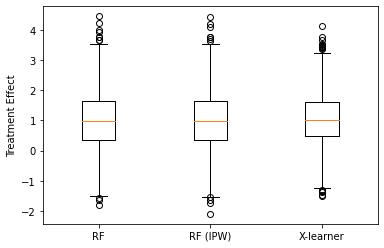

In [188]:
plt.figure()
plt.boxplot([rf_te.ite_pred, rf_ipsw_te.ite_pred, xl_te.ite_pred.flatten()], labels=['RF', 'RF (IPW)', 'X-learner'])
plt.ylabel('Treatment Effect')

plt.show()

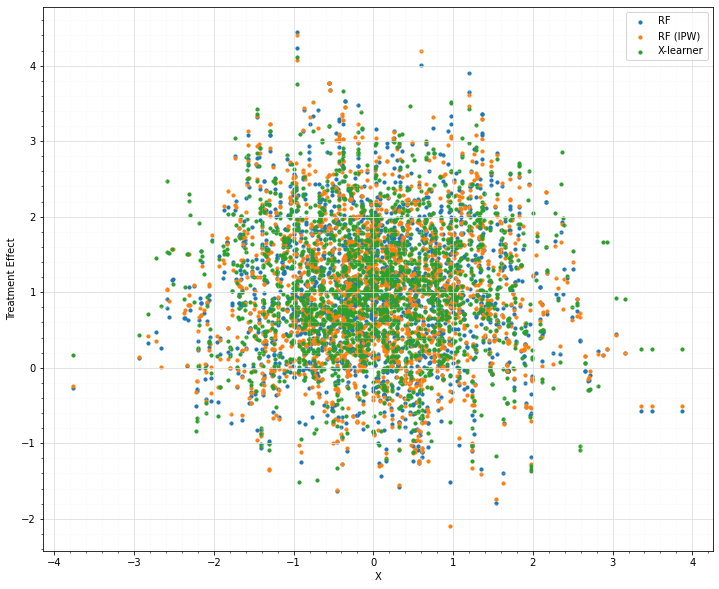

In [189]:
plt.figure(figsize=(12, 10))
m_size = 10
plt.scatter(x_test, rf_te.ite_pred, label="RF", s=m_size)
plt.scatter(x_test, rf_ipsw_te.ite_pred, label="RF (IPW)", s=m_size)
plt.scatter(x_test, xl_te.ite_pred, label="X-learner", s=m_size)
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.minorticks_on()
plt.xlabel('X')
plt.ylabel('Treatment Effect')
plt.legend()
plt.show()

## Step 3 - Heterogeneous effect

In the previous dataset, we observed the same effect value across all units. Such homogeneity does not always apply. In the second part of this exercise, we are going to explore a toy data where the effect is cleary heterogeneous.

### Step 3.1 - Problem setting

This dataset was generated via the [hte_generate.py](https://github.com/dmachlanski/CE888_2022/blob/main/lab4/data/hte_generate.py) script. Similarly to the previous dataset, the usual 'triangle' causal graph applies here as well.

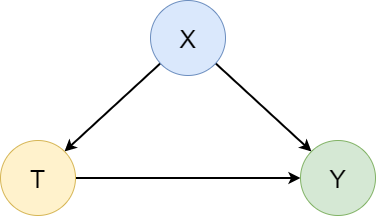

Here, we are interested in estimating the effect of T on Y, while also knowing that X affects both covariates. In addition, we know there is more than one effect group, which will become apparent once we start exploring the data visually.

### Step 3.2 - Metrics

We can use the same metrics as in the previous dataset ($ϵ_{ATE}$ and $ϵ_{PEHE}$), so there is no need to implement more - just reuse the existing code.

### Step 3.3 - Load the data

The data can be found [here](https://github.com/dmachlanski/CE888_2022/tree/main/lab4/data). It has been already split into training and testing sets (hte_train.csv and hte_test.csv).

In [85]:
# Load the dataset
# 1. Load hte_train.csv from: https://raw.githubusercontent.com/dmachlanski/CE888_2022/main/lab4/data/hte_train.csv
# 2. Load hte_test.csv from: https://raw.githubusercontent.com/dmachlanski/CE888_2022/main/lab4/data/hte_test.csv

!wget https://raw.githubusercontent.com/dmachlanski/CE888_2022/main/lab4/data/hte_train.csv
!wget https://raw.githubusercontent.com/dmachlanski/CE888_2022/main/lab4/data/hte_test.csv



# YOUR CODE HERE

--2022-02-11 13:57:52--  https://raw.githubusercontent.com/dmachlanski/CE888_2022/main/lab4/data/hte_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1401 (1.4K) [text/plain]
Saving to: ‘hte_train.csv’

hte_train.csv       100%[===================>]   1.37K  --.-KB/s    in 0s      

2022-02-11 13:57:52 (21.0 MB/s) - ‘hte_train.csv’ saved [1401/1401]

--2022-02-11 13:57:52--  https://raw.githubusercontent.com/dmachlanski/CE888_2022/main/lab4/data/hte_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 951 [text/plain]

In [110]:
hte_train_df = pd.read_csv("hte_train.csv")
hte_test_df = pd.read_csv("hte_test.csv")

hte_train_df.head()



,x,t,y,ite
0,0.023976,1.0,2.429799,2.3
1,-0.094244,1.0,2.363082,2.3
2,-0.020031,1.0,2.572256,2.3
3,0.006930,1.0,2.605929,2.3
4,1.156410,1.0,0.346002,-3.7


In [109]:
hte_test_df.head()

,x,t,y,ite
0,0.012826,1.0,2.492201,2.3
1,0.041816,1.0,2.388398,2.3
2,-0.096298,1.0,2.568154,2.3
3,-0.027440,1.0,2.649401,2.3
4,0.063349,1.0,2.514691,2.3


In [111]:
h_train_x = hte_train_df["x"].values.reshape(-1, 1)
h_train_t = hte_train_df["t"].values.reshape(-1, 1)
h_train_y = hte_train_df["y"].values.reshape(-1, 1)
h_train_ite=hte_train_df["ite"].values

h_test_x = hte_test_df["x"].values.reshape(-1, 1)
h_test_t = hte_test_df["t"].values.reshape(-1, 1)
h_test_y = hte_test_df["y"].values.reshape(-1, 1)
h_test_ite=hte_test_df["ite"].values

Now explore the data a bit. You can follow exactly the same process as with the sodium dataset - make histograms and scatter plots. Feel free to reuse the code from the previous parts of the exercise.

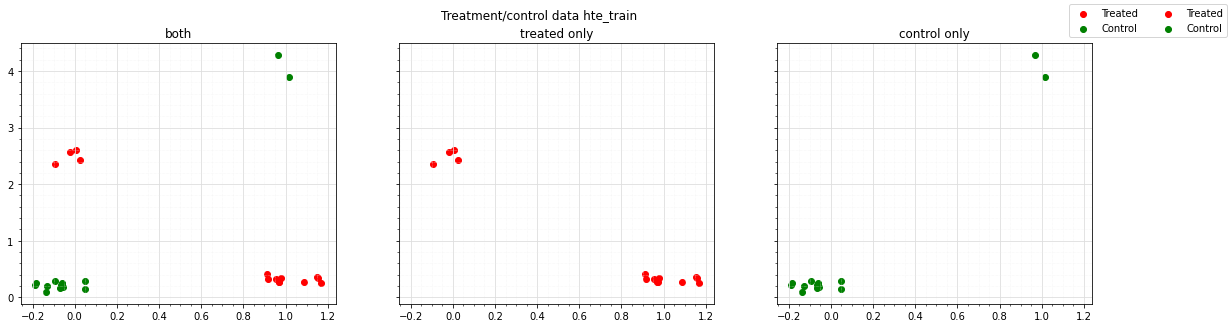

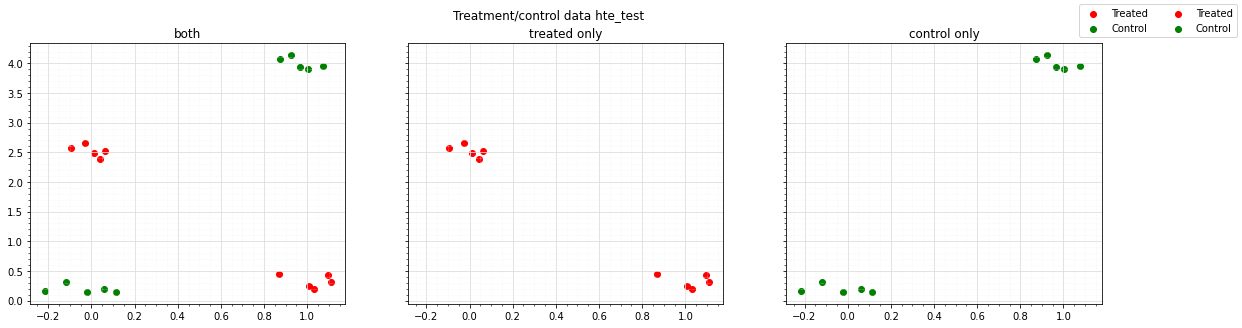

In [112]:
# Scatter plots - feel free to reuse the code from the sodium example.
# Hint: use DataFrame.loc to access treated and control units, or store the columns as numpy arrays.



data_visualizer(h_train_x, h_train_y, h_train_t, fig_suffix="hte_train").show()

data_visualizer(h_test_x, h_test_y, h_test_t, fig_suffix="hte_test").show()

# YOUR CODE HERE

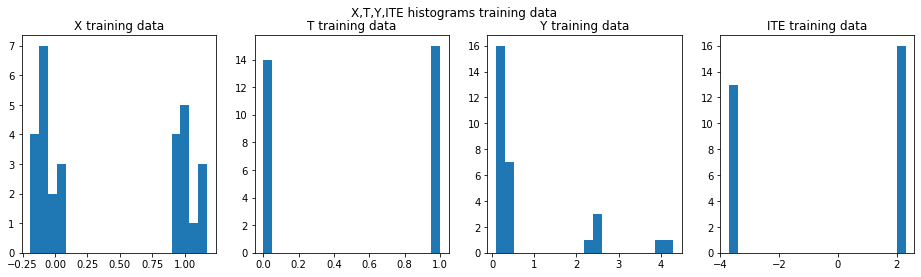

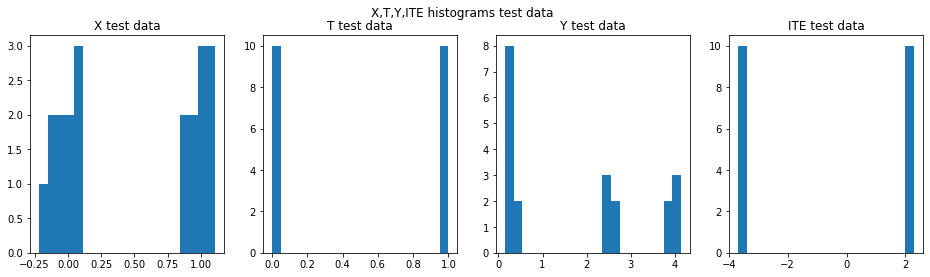

In [128]:
# Histograms - again, feel free to reuse the pre-existing code.

# YOUR CODE HERE


histogrammer(h_train_x, h_train_y, h_train_t, h_train_ite, fig_suffix="training data").show()

histogrammer(h_test_x, h_test_y, h_test_t, h_test_ite, fig_suffix="test data").show()

Once you do the plots, it should be quite obvious by now that we have two heterogeneous effect groups: ITE is either -3.7 or 2.3.

### Step 3.4 Data pre-processing

There is little (if any) data pre-processing necessary here. The dataset is already divided into training and testing. The only part left is scaling, depending on the type of models you plan to use.

In [216]:
# YOUR CODE HERE
scaler_x = StandardScaler()
h_train_x_s = h_train_x #scaler_x.fit_transform(h_train_x)
h_test_x_s = h_test_x #scaler_x.transform(h_test_x)


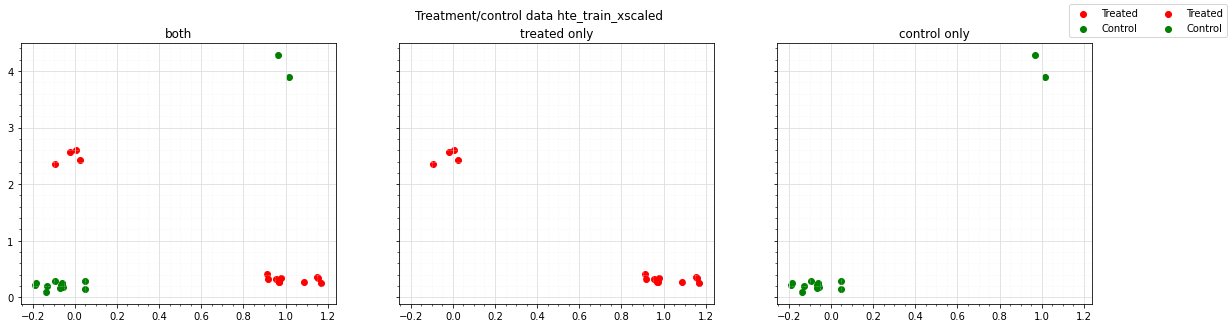

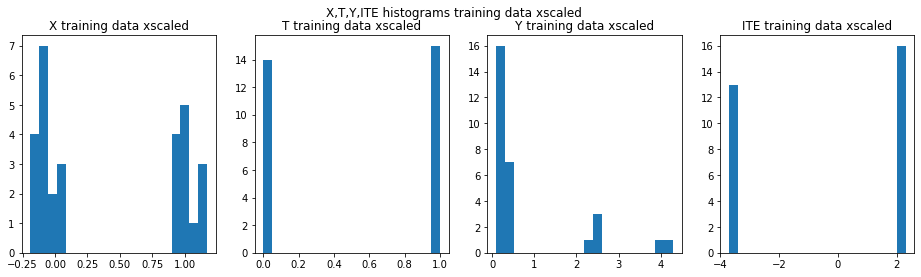

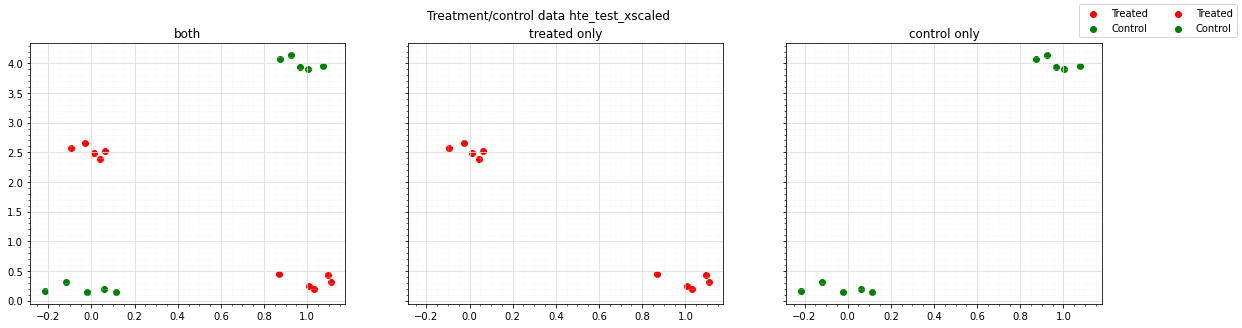

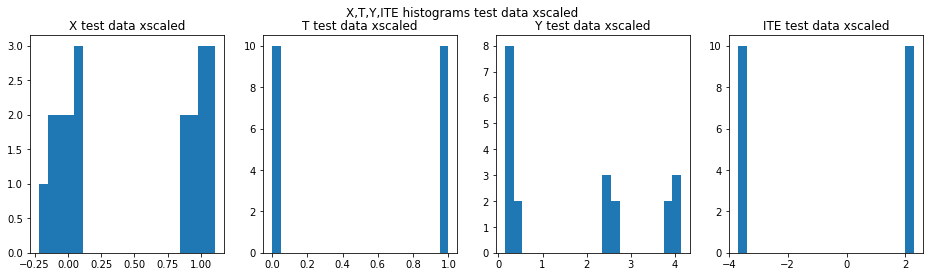

In [217]:
data_visualizer(h_train_x_s, h_train_y, h_train_t, fig_suffix="hte_train_xscaled").show()

histogrammer(h_train_x_s, h_train_y, h_train_t, h_train_ite, fig_suffix="training data xscaled").show()

data_visualizer(h_test_x_s, h_test_y, h_test_t, fig_suffix="hte_test_xscaled").show()

histogrammer(h_test_x_s, h_test_y, h_test_t, h_test_ite, fig_suffix="test data xscaled").show()

In [218]:
h_xt_train = np.hstack((h_train_x_s, h_train_t))
h_xt_train.flags.writeable = False

h_xt0_test = np.hstack((h_test_x_s, np.zeros_like(h_test_t)))
h_xt0_test.flags.writeable = False

h_xt1_test = np.hstack((h_test_x_s, np.ones_like(h_test_t)))
h_xt1_test.flags.writeable = False

### Step 3.5 Training

This is the modelling part. You should have the following types of models:
- Regressor (scikit-learn)
- **Weighted** regressor (IPW, scikit-learn)
- [CATE](https://econml.azurewebsites.net/reference.html#cate-estimators) estimator from EconML

For each of the above types, choose the models you like - it is up to you!

Steps:
1. Train the models on training data.
2. Predict outcomes and calculate effects, or predict effects directly, depending on the method used, on test data.

In [ ]:
# YOUR CODE HERE (add new code cells as necessary)

In [219]:
# regressor

from sklearn.linear_model import ARDRegression, BayesianRidge, LinearRegression, LogisticRegressionCV, LogisticRegression


h_linreg = LearnerOutputs.make(LinearRegression(), h_xt_train, h_train_y.flatten(), h_xt0_test, h_xt1_test, h_test_ite)

print(h_linreg)



LearnerOutputs(learner=LinearRegression(), ite_pred=array([0.07487559, 0.07487559, 0.07487559, 0.07487559, 0.07487559,
       0.07487559, 0.07487559, 0.07487559, 0.07487559, 0.07487559,
       0.07487559, 0.07487559, 0.07487559, 0.07487559, 0.07487559,
       0.07487559, 0.07487559, 0.07487559, 0.07487559, 0.07487559]), abs_ate=0.7748755871400502, pehe=3.0984564182098215)


In [220]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer

h_ardreg = LearnerOutputs.make(ARDRegression(), h_xt_train, h_train_y.flatten(), h_xt0_test, h_xt1_test, h_test_ite)

print(h_ardreg)

h_p_ardreg = LearnerOutputs.make(
    Pipeline([("scaler",QuantileTransformer()),("regressor",ARDRegression())]),
    h_xt_train, h_train_y.flatten(), h_xt0_test, h_xt1_test, h_test_ite
    )

print(h_p_ardreg)

LearnerOutputs(learner=ARDRegression(), ite_pred=array([0.00040002, 0.00040002, 0.00040002, 0.00040002, 0.00040002,
       0.00040002, 0.00040002, 0.00040002, 0.00040002, 0.00040002,
       0.00040002, 0.00040002, 0.00040002, 0.00040002, 0.00040002,
       0.00040002, 0.00040002, 0.00040002, 0.00040002, 0.00040002]), abs_ate=0.7004000202058277, pehe=3.080675281217468)
LearnerOutputs(learner=Pipeline(steps=[('scaler', QuantileTransformer()),
                ('regressor', ARDRegression())]), ite_pred=array([0.00048167, 0.00048167, 0.00048167, 0.00048167, 0.00048167,
       0.00048167, 0.00048167, 0.00048167, 0.00048167, 0.00048167,
       0.00048167, 0.00048167, 0.00048167, 0.00048167, 0.00048167,
       0.00048167, 0.00048167, 0.00048167, 0.00048167, 0.00048167]), abs_ate=0.7004816685325056, pehe=3.0806938452157304)


n_quantiles (1000) is greater than the total number of samples (29). n_quantiles is set to n_samples.


In [221]:
# weighted regressor

h_weights = get_ps_weights(LogisticRegressionCV(),h_train_x, h_train_t)

h_weightedreg = LearnerOutputs.make_sampleweights(
    LinearRegression(), h_xt_train, h_train_y.flatten(), h_xt0_test, h_xt1_test,
    h_weights, h_test_ite
)


print(h_weightedreg)

LearnerOutputs(learner=LinearRegression(), ite_pred=array([-0.15000087, -0.15000087, -0.15000087, -0.15000087, -0.15000087,
       -0.15000087, -0.15000087, -0.15000087, -0.15000087, -0.15000087,
       -0.15000087, -0.15000087, -0.15000087, -0.15000087, -0.15000087,
       -0.15000087, -0.15000087, -0.15000087, -0.15000087, -0.15000087]), abs_ate=0.5499991299551714, pehe=3.0499998431067907)


In [222]:
# CATE

from econml.iv.dml import OrthoIV
from econml.dr import ForestDRLearner

h_forest = LearnerOutputs.make_cate(ForestDRLearner(), h_train_x_s, h_train_y, h_train_t, h_test_x_s, h_test_ite)

print(h_forest)



'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


LearnerOutputs(learner=<econml.dr._drlearner.ForestDRLearner object at 0x7f4c2acd2bd0>, ite_pred=array([[0.10224266],
       [0.10224266],
       [0.10224266],
       [0.10224266],
       [0.10224266],
       [0.10224266],
       [0.10224266],
       [0.10224266],
       [0.10224266],
       [0.10224266],
       [0.10224266],
       [0.10224266],
       [0.10224266],
       [0.10224266],
       [0.10224266],
       [0.10224266],
       [0.10224266],
       [0.10224266],
       [0.10224266],
       [0.10224266]]), abs_ate=0.8022426556426913, pehe=3.1054135438831065)


In [223]:
from econml.iv.dr import LinearDRIV

#h_linDRIV = LearnerOutputs.make_cate(LinearDRIV(), h_train_x, h_train_y, h_train_t, h_test_x, h_test_ite)

#print(h_linDRIV)

### Step 3.6 Evaluation

Here, use both metrics $ϵ_{ATE}$ and $ϵ_{PEHE}$ to evaluate the performance of your models. Feel free to perform any other form of evaluation as we did before (confidence intervals, box plots, etc.).

In [197]:
# Evaluate your predictions with 'abs_ate' and 'pehe' functions.

# YOUR CODE HERE (add new code cells as necessary)

In [224]:
# Error on ATE
# Use our 'abs_ate' function, true ITEs and predicted ITEs to get the measurements.

lin_ate = h_linreg.abs_ate
ard_ate= h_ardreg.abs_ate
p_ard_ate = h_p_ardreg.abs_ate
h_weightedreg_ate = h_weightedreg.abs_ate
h_forest_ate = h_forest.abs_ate
#h_linDRIV_ate = h_linDRIV.abs_ate


# PEHE
# Use our 'pehe' function, true ITEs and predicted ITEs to get the measurements.
lin_pehe = h_linreg.pehe
ard_pehe= h_ardreg.pehe
p_ard_pehe = h_p_ardreg.pehe
h_weightedreg_pehe = h_weightedreg.pehe
h_forest_pehe = h_forest.pehe
#h_linDRIV_pehe = h_linDRIV.pehe

In [225]:
results = []
results.append(['lin reg', lin_ate, lin_pehe])
results.append(['ARD reg', ard_ate, ard_pehe])
results.append(['piped ARD reg', p_ard_ate, p_ard_pehe])
results.append(['lin reg (IPW)', h_weightedreg_ate, h_weightedreg_pehe])
results.append(['CATE (ForestDR)', h_forest_ate, h_forest_pehe])

cols = ['Method', 'ATE test', 'PEHE test']

df = pd.DataFrame(results, columns=cols)
df

,Method,ATE test,PEHE test
0,lin reg,0.774876,3.098456
1,ARD reg,0.700400,3.080675
2,piped ARD reg,0.700482,3.080694
3,lin reg (IPW),0.549999,3.050000
4,CATE (ForestDR),0.802243,3.105414


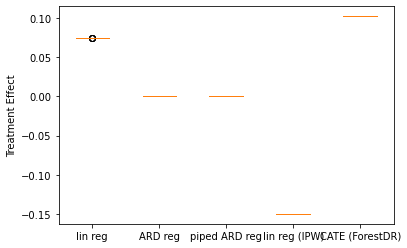

In [229]:
plt.figure()
plt.boxplot(
    [h_linreg.ite_pred, h_ardreg.ite_pred, h_p_ardreg.ite_pred, h_weightedreg.ite_pred, h_forest.ite_pred.flatten()],
    labels=['lin reg', 'ARD reg', 'piped ARD reg', 'lin reg (IPW)', 'CATE (ForestDR)'])
plt.ylabel('Treatment Effect')

plt.show()

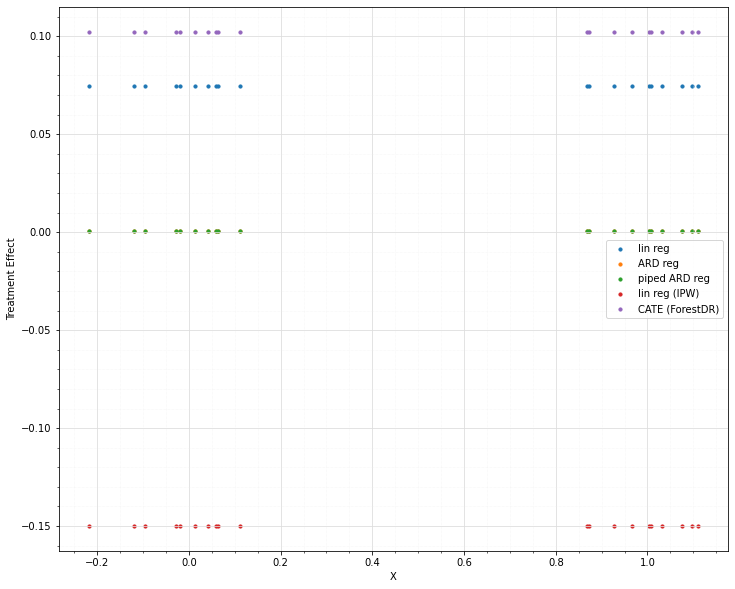

In [230]:
plt.figure(figsize=(12, 10))
m_size = 10
plt.scatter(h_test_x_s, h_linreg.ite_pred, label="lin reg", s=m_size)
plt.scatter(h_test_x_s, h_ardreg.ite_pred, label="ARD reg", s=m_size)
plt.scatter(h_test_x_s, h_p_ardreg.ite_pred, label="piped ARD reg", s=m_size)
plt.scatter(h_test_x_s, h_weightedreg.ite_pred, label="lin reg (IPW)", s=m_size)
plt.scatter(h_test_x_s, h_forest.ite_pred.flatten(), label="CATE (ForestDR)", s=m_size)
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.minorticks_on()
plt.xlabel('X')
plt.ylabel('Treatment Effect')
plt.legend()
plt.show()

## Final comment

Make sure to upload this notebook to your GitHub repo once you finished!